# Introduction to Scikit-fem

We have already seen that Poisson's problem in 1d with unit load can be solved as follows:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import skfem as fem
from skfem.helpers import dot, grad 

@fem.BilinearForm
def a(u, v, w):
    # Return the integrand in the bilinear form a(u, v)
    return dot(grad(u), grad(v)) 

def f(x):
    return 1
@fem.LinearForm
def L(v, w):
    x = w.x[0] # quadrature points for numerical integration
    # Return the integrand in the linear form L(v) 
    return f(x) * v 

n = 4
xs = np.linspace(0,1, n+1)

mesh = fem.MeshLine(xs) 
basis = fem.Basis(mesh, fem.ElementLineP1())
K = a.assemble(basis)
F = L.assemble(basis)
boundary_dofs = basis.get_dofs()
u = fem.solve(*fem.condense(K, F, D=boundary_dofs))
print(f'{u = }')

u = array([0.     , 0.09375, 0.125  , 0.09375, 0.     ])


Recall that the solution vector `u` contains the coefficients of the Galerkin solution $u_S$ in the global basis $\phi_0, \dots, \phi_n$,
defined on the mesh

$$
0 = x_0 < x_1 < \dots < x_n = 1.
$$


(Here $\phi_0$ and $\phi_n$ are the auxiliary basis functions that do not vanish on the boundary.) Recall, furthermore, that the basis functions satisfy

$$
\phi_j(x_k) = \delta_{jk},
$$

and that this allows us to interpret the coefficients `u` as the point values of $u_S$ at the nodes $x_j$, $j=0,\dots,n$.
In order to fully understand `u` we need to understand the indexing that Scikit-fem is using.

In [2]:
print(f'Number of basis functions (before condensation): {basis.N = }')
print(f'Number of elements (= n): {mesh.nelements = }')
print(f'Indices of boundary nodes: {mesh.boundary_nodes()  = }')
print(f'Indices of boundary nodes: {boundary_dofs.nodal_ix = }')
print(f'Indices of interior nodes: {mesh.interior_nodes() = }')
print(f'Locations of nodes: {mesh.p = }')

Number of basis functions (before condensation): basis.N = 5
Number of elements (= n): mesh.nelements = 4
Indices of boundary nodes: mesh.boundary_nodes()  = array([0, 4])
Indices of boundary nodes: boundary_dofs.nodal_ix = array([0, 4])
Indices of interior nodes: mesh.interior_nodes() = array([1, 2, 3])
Locations of nodes: mesh.p = array([[0.  , 0.25, 0.5 , 0.75, 1.  ]])


We see that `u` is indexed in the natural inceasing order with `u[j]` corresponding to $u_S(x_j)$. 
We can plot $u_S$ simply as follows:

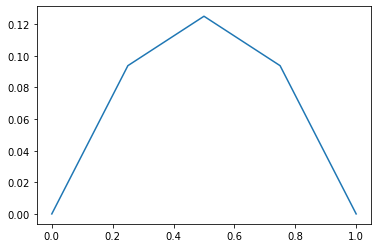

In [3]:
plt.plot(xs, u);

We can use `mesh.p` instead of `xs`, however, we need to first remove its singleton dimension. Scikit-fem can solve multidimensional problems, and the seemingly useless dimension in `mesh.p` is needed to treat problems of any dimension in a systematic way. 

mesh.p             = array([[0.  , 0.25, 0.5 , 0.75, 1.  ]])
np.squeeze(mesh.p) =  array([0.  , 0.25, 0.5 , 0.75, 1.  ])
mesh.p[0]          =  array([0.  , 0.25, 0.5 , 0.75, 1.  ])
np.shape(mesh.p)  = (1, 5)
np.shape(xs_mesh) = (5,)


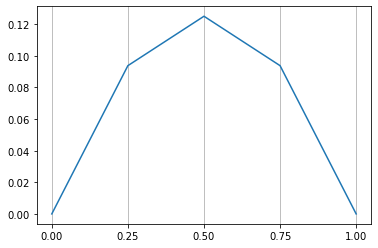

In [4]:
# There are two easy ways to get rid of the extra dimension
print(f'{mesh.p             = }')
print(f'{np.squeeze(mesh.p) =  }')
print(f'{mesh.p[0]          =  }')

xs_mesh = mesh.p[0]
print(f'{np.shape(mesh.p)  = }')
print(f'{np.shape(xs_mesh) = }')

plt.plot(xs_mesh, u)
plt.gca().set_xticks(xs_mesh)
plt.grid(axis='x');

# Quadrature points

Let's have a closer look at the last parameter `w` of forms and functionals. 
We have already seen that it contains the array `w.x` of quadrature points for numerical integration.
Like `mesh.p` this array has a singleton dimension (that is again needed to handle problems of any dimension).

In [5]:
@fem.Functional
def print_info(w):
    print(f'{w.x             = }')
    print(f'{np.squeeze(w.x) =   }')
    print(f'{w.x[0]          =  }')        
    return 0

print('Mesh with a single element')
print_info.assemble(fem.Basis(fem.MeshLine([0,1]), fem.ElementLineP1()));
print('Mesh with two elements')
print_info.assemble(fem.Basis(fem.MeshLine([0,1,2]), fem.ElementLineP1()));

Mesh with a single element
w.x             = array([[[0.21132487, 0.78867513]]])
np.squeeze(w.x) =   array([0.21132487, 0.78867513])
w.x[0]          =  array([[0.21132487, 0.78867513]])
Mesh with two elements
w.x             = array([[[0.21132487, 0.78867513],
        [1.21132487, 1.78867513]]])
np.squeeze(w.x) =   array([[0.21132487, 0.78867513],
       [1.21132487, 1.78867513]])
w.x[0]          =  array([[0.21132487, 0.78867513],
       [1.21132487, 1.78867513]])


We see that `w.x` is essentially a two dimensional array. Its rows give the quadrature points in each element. 
The only correct way to remove the singleton dimension is to use `w.x[0]`, since [squeeze](https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html) removes all singleton dimensions and this will remove two dimensions in the corner case where the mesh has a single element.  

Scikit-fem uses the [Gauss-Legendre quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature).
The number of quadrature points depends on the degree of basis functions. Two points are used for the P1 basis, and the corresponding numerical integration yields an exact result for polynomials of degree 3 or less. 

The Gauss-Legendre quadrature is defined on the interval $[-1,1]$. To apply it on an interval $[a,b]$ we need to map quadrature points $\xi_1, \dots, \xi_K$ given on $[-1,1]$ to the corresponding quadrature points $\tilde \xi_1, \dots, \tilde \xi_K$ on $[a,b]$ by using an affine transformation. The transformation is given by the [change of interval](https://en.wikipedia.org/wiki/Gaussian_quadrature#Change_of_interval) formula

$$
\tilde \xi_k = \frac{b - a}2 \xi_k + \frac{a + b}2, \quad k = 1,\dots, K.
$$


For $K=2$,

$$
\xi_1 = -\frac 1{\sqrt 3}, \quad \xi_2 = \frac 1{\sqrt 3}.
$$

In [6]:
xi2 = 1/np.sqrt(3)
xis = np.array([-xi2, xi2])

def change_of_interval(xi, a, b):
    return (b - a)/2 * xi + (a + b)/2

print(f'Quadrature points on [0,1]: {change_of_interval(xis, 0, 1)}')
print(f'Quadrature points on [1,2]: {change_of_interval(xis, 1, 2)}')

Quadrature points on [0,1]: [0.21132487 0.78867513]
Quadrature points on [1,2]: [1.21132487 1.78867513]


# Mesh refinement

Given a mesh, we can create a finer mesh containing the points of the original mesh.

mesh_finer.nelements = 8
xs_mesh_finer = array([0.   , 0.25 , 0.5  , 0.75 , 1.   , 0.125, 0.375, 0.625, 0.875])


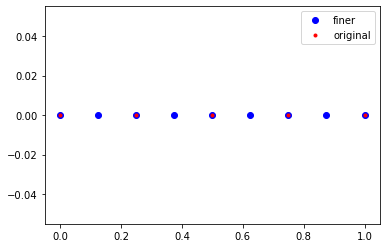

In [7]:
mesh_finer = mesh.refined(1)
xs_mesh_finer = mesh_finer.p[0]
print(f'{mesh_finer.nelements = }')
print(f'{xs_mesh_finer = }')
plt.plot(xs_mesh_finer, np.zeros_like(xs_mesh_finer), 'ob', label='finer')
plt.plot(xs_mesh, np.zeros_like(xs_mesh), '.r', label='original')
plt.legend();

The mesh points are not in the increasing order, and we need to be careful with indices. Subtleties with indexing can not be avoided in the case of higher order basis functions or higher dimensional problems. Let's solve the Poisson problem in the finer mesh.

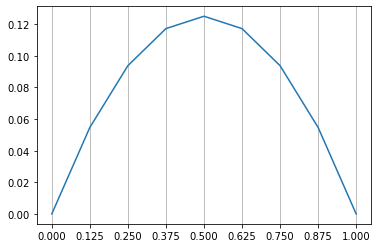

In [8]:
basis_finer = fem.Basis(mesh_finer, fem.ElementLineP1())
u_finer = fem.solve(*fem.condense(
    a.assemble(basis_finer), 
    L.assemble(basis_finer), 
    D=basis_finer.get_dofs()))

ix = np.argsort(xs_mesh_finer)
plt.plot(xs_mesh_finer[ix], u_finer[ix])
plt.gca().set_xticks(xs_mesh_finer)
plt.grid(axis='x');

# P2 finite element

The P2 basis functions on the reference domain $[0,1]$ give a basis of $\mathbb P_2(0,1)$.
We will plot them using Scikit-fem, but let us first plot the P1 basis functions that we already familiar with.

xs_mesh_ref = array([0., 1.])


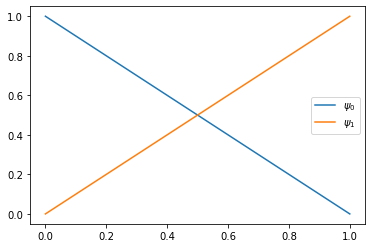

In [9]:
mesh_ref = fem.MeshLine([0,1]) 
xs_mesh_ref = mesh_ref.p[0]
print(f'{xs_mesh_ref = }')
basis_ref_P1 = fem.Basis(mesh_ref, fem.ElementLineP1())
for j in range(basis_ref_P1.N):
    u = np.zeros(basis_ref_P1.N) 
    u[j] = 1
    plt.plot(xs_mesh_ref, u, label=f'$\psi_{j}$')
plt.legend();

Plotting the P2 basis functions is harder. As they are second order polynomials, we can not capture their features using `mesh_ref` that consists of only two points. We can plot them in a finer mesh by using mesh refinement, implemented by `refinterp`. This method refines a mesh and returns the point values of a function, given in a basis over the original mesh, at the nodes of the refined mesh. These point values correspond to coefficients in the P1 basis of the refined mesh, regardless whether the original basis is P1 or not.  

mesh_plot.nelements = 128
np.size(u_plot) = 129


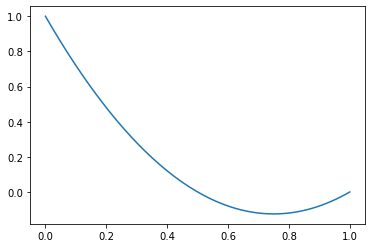

In [10]:
basis_ref_P2 = fem.Basis(mesh_ref, fem.ElementLineP2())
u = np.zeros(basis_ref_P2.N) 
u[0] = 1 # coefficients of the zeroth basis function
mesh_plot, u_plot = basis_ref_P2.refinterp(u, nrefs=7)
xs_mesh_plot = mesh_plot.p[0]
ix = np.argsort(xs_mesh_plot)
plt.plot(xs_mesh_plot[ix], u_plot[ix])
print(f'{mesh_plot.nelements = }')
print(f'{np.size(u_plot) = }')

We can plot the P2 basis functions in arbitrary points by using `probes`. This creates such a matrix that applying it to a vector of coefficients gives point values of the function corresponding to the coefficients. We also need the inverse operation of `squeeze` called [expand_dims](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html). 

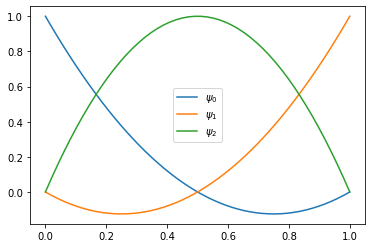

In [11]:
xs_plot = np.linspace(0, 1)
probe = basis_ref_P2.probes(np.expand_dims(xs_plot, axis=0))

for j in range(basis_ref_P2.N):
    u = np.zeros(basis_ref_P2.N) 
    u[j] = 1
    u_plot = probe @ u
    plt.plot(xs_plot, u_plot, label=f'$\psi_{j}$')
plt.legend();


Let's also plot the global basis functions.

Number of basis functions: basis.N = 9


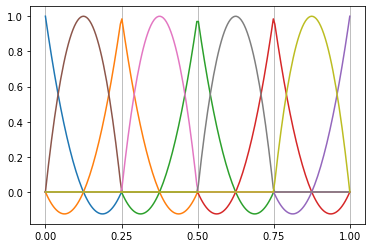

In [12]:
n = 4
xs = np.linspace(0,1, n+1)

mesh = fem.MeshLine(xs) 
basis = fem.Basis(mesh, fem.ElementLineP2())

print(f'Number of basis functions: {basis.N = }')

xs_plot = np.linspace(0,1, 200)
probe = basis.probes(np.expand_dims(xs_plot, axis=0))

for j in range(basis.N):
    u = np.zeros(basis.N) 
    u[j] = 1
    u_plot = probe @ u
    plt.plot(xs_plot, u_plot)

plt.gca().set_xticks(xs_mesh)
plt.grid(axis='x');

# Comparison of solutions using P1 and P2 finite elements

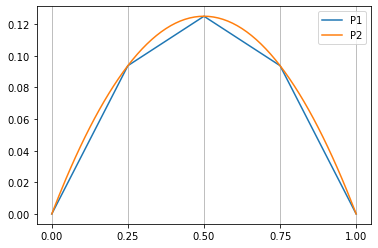

In [13]:
n = 4
xs = np.linspace(0,1, n+1)

mesh = fem.MeshLine(xs) 
def solve_and_plot_poisson(elem):
    basis = fem.Basis(mesh, elem)
    u = fem.solve(*fem.condense(
        a.assemble(basis), 
        L.assemble(basis), 
        D=basis.get_dofs()))
    mesh_plot, u_plot = basis.refinterp(u, nrefs=5)
    xs_mesh_plot = mesh_plot.p[0]
    ix = np.argsort(xs_mesh_plot)
    plt.plot(xs_mesh_plot[ix], u_plot[ix], label=f'P{elem.maxdeg}')

solve_and_plot_poisson(fem.ElementLineP1())
solve_and_plot_poisson(fem.ElementLineP2())
plt.gca().set_xticks(xs)
plt.grid(axis='x')
plt.legend();